# Capítulo 2: Tokens e Embeddings

Este notebook é uma adaptação prática para o curso de IA Avançado.
**Objetivo:** Entender como as LLMs "leem" nossos logs de fábrica e part numbers.

---

## 1. Instalação das Dependências
Vamos usar a biblioteca `transformers` da Hugging Face, que é o padrão da indústria.

In [1]:
!pip install transformers torch scipy matplotlib scikit-learn

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl (8.0 MB)

   ---------------------------------------- 0/5 [scikit-learn]
   ---------------------------------------- 0/5 [scikit-learn]
   ---------------------------------------- 0/5 [scikit-learn]
   ---------------------------------------- 0/5 [scikit-learn]
   ---------------------------------------- 0/5 [scikit-lea


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Tokenização: Como a máquina lê?

Modelos de IA não leem strings. Eles leem números (IDs). O processo de quebrar texto em pedaços e converter para números chama-se **Tokenização**.

Vamos usar o **BERT em Português** (treinado pela NeuralMind) para ver como ele lida com nossa língua.

In [2]:
from transformers import AutoTokenizer

# Carregando um tokenizador pré-treinado em PT-BR
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizador carregado com sucesso!")

c:\Users\fpf\Documents\jpmarinw\semana3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\fpf\Documents\jpmarinw\semana3\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fpf\.cache\huggingface\hub\models--neuralmind--bert-base-portuguese-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administ

Tokenizador carregado com sucesso!


### 2.1 Teste Básico (Linguagem Natural)
Vamos ver como ele lida com uma frase comum de chão de fábrica.

In [3]:
texto_simples = "O operador desligou a esteira."

# 1. Tokenizar (Quebrar em pedaços)
tokens = tokenizer.tokenize(texto_simples)

# 2. Converter para IDs (Números)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Texto Original: {texto_simples}")
print(f"Tokens: {tokens}")
print(f"IDs:    {ids}")

Texto Original: O operador desligou a esteira.
Tokens: ['O', 'operador', 'deslig', '##ou', 'a', 'este', '##ira', '.']
IDs:    [231, 15348, 15238, 203, 123, 860, 364, 119]


### 2.2 O Pesadelo Industrial: Part Numbers
Aqui é onde modelos genéricos costumam falhar. Vamos ver como o BERT lida com um código de microcontrolador comum: `STM32F407`.

In [4]:
texto_tecnico = "Falha no componente STM32F407 durante o reflow."

tokens_tec = tokenizer.tokenize(texto_tecnico)
ids_tec = tokenizer.convert_tokens_to_ids(tokens_tec)

print(f"Texto: {texto_tecnico}")
print("Tokens:")
print(tokens_tec)

Texto: Falha no componente STM32F407 durante o reflow.
Tokens:
['Fal', '##ha', 'no', 'componente', 'ST', '##M', '##32', '##F', '##40', '##7', 'durante', 'o', 'ref', '##low', '.']


**Análise:** Observe como ele quebrou o `STM32F407`.
Provavelmente você vê algo como `STM`, `##32`, `##F`, etc.
O `##` significa que aquele pedaço faz parte da palavra anterior.

> **Discussão:** Se o modelo quebra o part number, ele perde o significado de "entidade única". Para a IA, `STM32` e `ESP32` podem parecer parentes próximos só porque terminam com `32`, o que é perigoso.

## 3. Embeddings: O Significado Matemático

Tokens são apenas números inteiros. Eles não carregam sentido.
Os **Embeddings** são a camada que transforma esse número inteiro em um **Vetor** (uma lista de floats) que representa o significado.

Vamos extrair os embeddings do próprio modelo BERT.

In [5]:
from transformers import AutoModel
import torch

# Carregando o MODELO (o cérebro que gera os vetores)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    # Prepara o input (adiciona tokens especiais [CLS] e [SEP])
    inputs = tokenizer(text, return_tensors="pt")

    # Passa pelo modelo (sem calcular gradientes para ser rápido)
    with torch.no_grad():
        outputs = model(**inputs)

    # Pega o último estado oculto (last_hidden_state)
    # Shape: (Batch_Size, Num_Tokens, Embedding_Dim)
    # Pegamos a média de todos os tokens para ter uma representação da frase
    sentence_embedding = outputs.last_hidden_state.mean(dim=1)
    return sentence_embedding[0].numpy()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


### 3.1 Aritmética de Fábrica (Similaridade de Cosseno)

Vamos provar que o modelo entende que **"Resistor"** é mais parecido com **"Capacitor"** do que com **"Gerente"**.

In [6]:
from scipy.spatial.distance import cosine

# Palavras para testar
vetor_resistor = get_embedding("Resistor")
vetor_capacitor = get_embedding("Capacitor")
vetor_gerente = get_embedding("Gerente")
vetor_almoco = get_embedding("Almoço")

# Função para calcular similaridade (1 - distância)
def similaridade(vec1, vec2):
    return 1 - cosine(vec1, vec2)

print(f"Similaridade Resistor <-> Capacitor: {similaridade(vetor_resistor, vetor_capacitor):.4f}")
print(f"Similaridade Resistor <-> Gerente:   {similaridade(vetor_resistor, vetor_gerente):.4f}")
print(f"Similaridade Resistor <-> Almoço:    {similaridade(vetor_resistor, vetor_almoco):.4f}")

Similaridade Resistor <-> Capacitor: 0.8378
Similaridade Resistor <-> Gerente:   0.5026
Similaridade Resistor <-> Almoço:    0.4533


## 4. Visualização 2D (O Mapa da Fábrica)

Embeddings têm 768 dimensões (impossível de ver). Vamos usar **PCA** para esmagar isso em 2 dimensões (X e Y) e plotar um gráfico.

Se o modelo for inteligente, ele vai agrupar as peças em um canto e as ferramentas em outro.

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


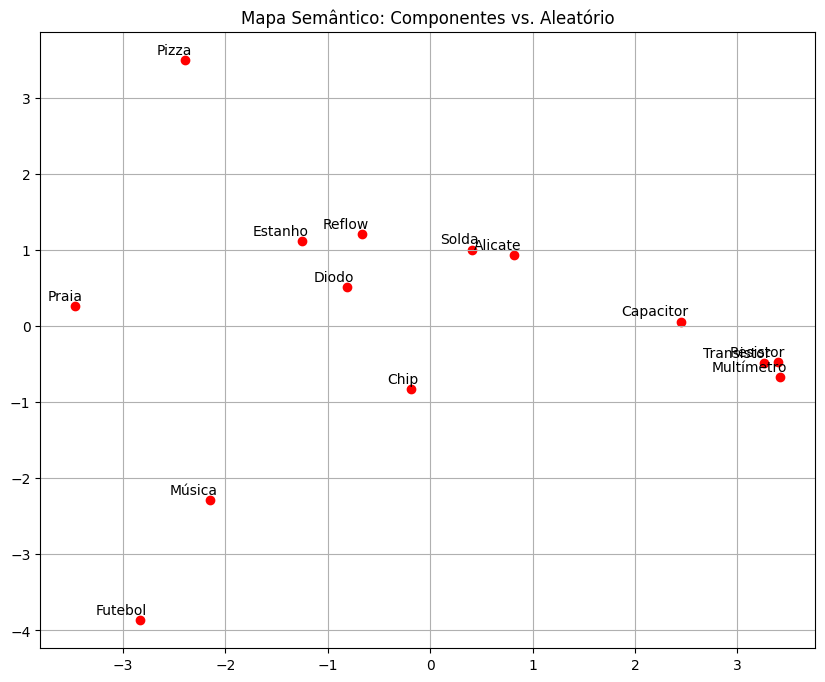

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Lista de palavras misturadas
palavras = [
    # Componentes
    "Resistor", "Capacitor", "Diodo", "Transistor", "Chip",
    # Ferramentas/Processos
    "Solda", "Multímetro", "Alicate", "Reflow", "Estanho",
    # Coisas aleatórias (para controle)
    "Pizza", "Futebol", "Praia", "Música"
]

# Gerar embeddings
vetores = [get_embedding(p) for p in palavras]

# Reduzir para 2D usando PCA
pca = PCA(n_components=2)
vetores_2d = pca.fit_transform(vetores)

# Plotar
plt.figure(figsize=(10, 8))
plt.scatter(vetores_2d[:, 0], vetores_2d[:, 1], c='red')

for i, palavra in enumerate(palavras):
    plt.annotate(palavra, xy=(vetores_2d[i, 0], vetores_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title("Mapa Semântico: Componentes vs. Aleatório")
plt.grid(True)
plt.show()

## 5. Desafio para a Turma

1.  Adicione um Part Number real na lista de visualização.
2.  Onde ele caiu no gráfico? Perto dos componentes ou isolado?
3.  Tente adicionar a palavra "Banco". Ela cai perto de "Assento" ou perto de "Dinheiro"? Como o contexto mudaria isso?